<a href="https://colab.research.google.com/github/MuhammadIeyan/Cross-Flow-Heat-Exchanger-Solver/blob/main/Cross_Flow_Heat_Exchanger_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross Flow Heat Exchanger Solver
**Description:**

Numerical solver for a smooth copper pipe carrying hot engine oil cooled by cross-flow air. The script calculates heat transfer coefficients using Hilpert (external) and Petukhov (internal) correlations, solves for outlet temperature iteratively, and visualizes the thermal profile along the pipe length.

**Physics Models:**


*   External Flow: Hilpert Correlation (Cylinder in Cross Flow)
*   Internal Flow: Petukhov (Turbulent) / Constant Ts (Laminar)
*   Fluid Properties: Temperature-dependent (Interpolated)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [17]:
# Geometry & Materials
L = 5.0                  # Length [m]
D_in = 0.022             # Inner Dia [m]
D_out = 0.025            # Outer Dia [m]
k_copper = 401.0         # Copper Conductivity [W/mK]

# External Air (Fixed)
T_air = 22.0
v_air = 20.0
P_air = 101000.0

# Air Properties
k_air = 0.02514
Pr_air = 0.7309
mu_air = 1.516e-5
rho_air = 1.204
Re_air = (rho_air * v_air * D_out) / mu_air

# Hilpert Correlation for Air
if 40 < Re_air <= 4000: C, m = 0.683, 0.466
elif 4000 < Re_air <= 40000: C, m = 0.193, 0.618
else: C, m = 0.027, 0.805

Nu_air = C * (Re_air**m) * (Pr_air**(1/3))
h_air = (k_air / D_out) * Nu_air

In [18]:
# Oil Properties Interpolation Functions
T_data = np.array([100, 120])
rho_data = np.array([840, 828.9])
cp_data = np.array([2220, 2308])
k_data = np.array([0.1357, 0.1347])
mu_data = np.array([0.01718, 0.01029])
Pr_data = np.array([279.1, 176.3])

f_rho = interp1d(T_data, rho_data, fill_value="extrapolate")
f_cp  = interp1d(T_data, cp_data,  fill_value="extrapolate")
f_k   = interp1d(T_data, k_data,   fill_value="extrapolate")
f_mu  = interp1d(T_data, mu_data,  fill_value="extrapolate")
f_Pr  = interp1d(T_data, Pr_data,  fill_value="extrapolate")

In [19]:
# SOLVER FUNCTION
def solve_pipe(v_oil_input, label_text):
    T_in = 105.0
    T_guess = 100.0

    # Quick Iteration to find U and m_dot
    for _ in range(5):
        T_mean = (T_in + T_guess) / 2

        # Props
        rho = float(f_rho(T_mean))
        mu = float(f_mu(T_mean))
        cp = float(f_cp(T_mean))
        k = float(f_k(T_mean))
        Pr = float(f_Pr(T_mean))

        # Flow
        m_dot = rho * (np.pi * D_in**2 / 4) * v_oil_input
        Re = (rho * v_oil_input * D_in) / mu

        # Internal Nusselt
        if Re > 2300:
            f = 1 / ((0.79 * np.log(Re) - 1.64)**2)
            Nu = 0.023 * (Re**0.8) * (Pr**0.3)
        else:
            Nu = 3.66 # Laminar

        h_oil = (k / D_in) * Nu

        # Overall U (Inner Area Basis)
        R_val = 1/(h_oil*np.pi*D_in*L) + np.log(D_out/D_in)/(2*np.pi*k_copper*L) + 1/(h_air*np.pi*D_out*L)
        UA = 1.0 / R_val
        U_inner = UA / (np.pi * D_in * L)

        # NTU & Outlet
        NTU = UA / (m_dot * cp)
        T_out_calc = T_air + (T_in - T_air) * np.exp(-NTU)
        T_guess = T_out_calc

    # Generate Profile Data
    x = np.linspace(0, L, 100)
    decay = (U_inner * np.pi * D_in) / (m_dot * cp)
    T_profile = T_air + (T_in - T_air) * np.exp(-decay * x)

    print(f"--- Scenario: {label_text} ---")
    print(f"Velocity: {v_oil_input} m/s")
    print(f"Outlet Temp: {T_guess:.2f} C")
    print(f"Total Drop: {T_in - T_guess:.2f} C\n")

    return x, T_profile

--- Scenario: Actual (Homework) ---
Velocity: 5.0 m/s
Outlet Temp: 104.06 C
Total Drop: 0.94 C

--- Scenario: Low Velocity Case ---
Velocity: 0.1 m/s
Outlet Temp: 97.52 C
Total Drop: 7.48 C



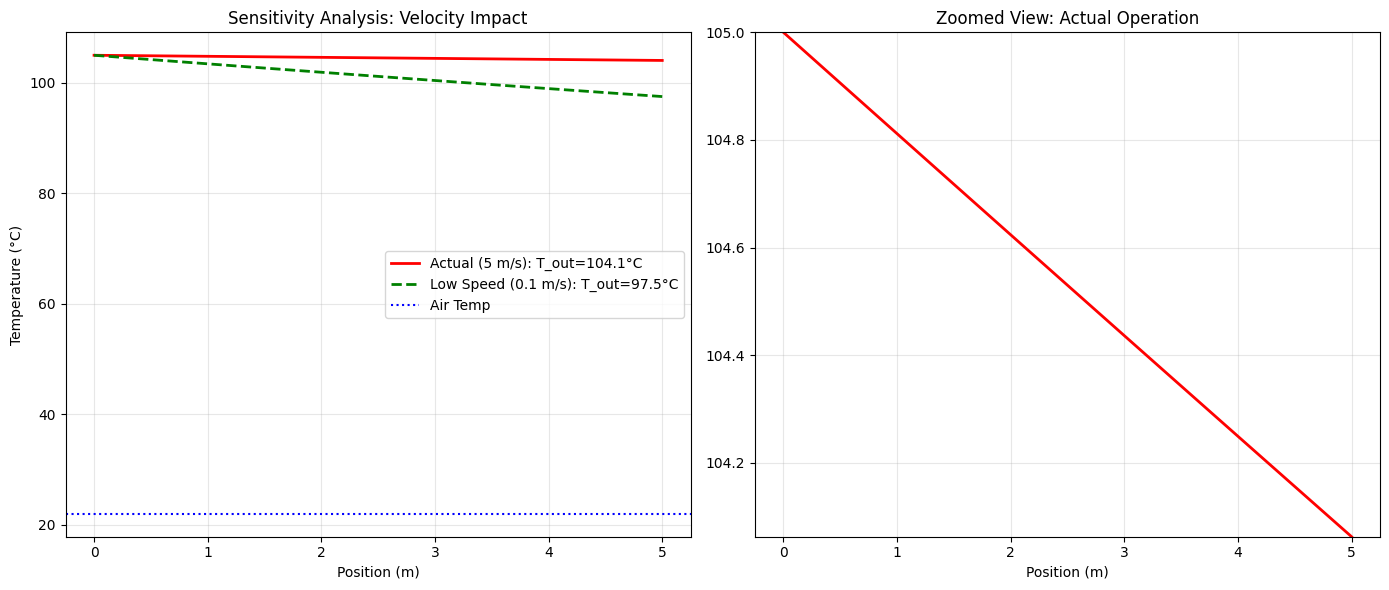

In [20]:
# RUN SCENARIOS & PLOT

# Scenario A: Fast Flow
x_fast, T_fast = solve_pipe(5.0, "Actual (Homework)")

# Scenario B: Sensitivity Analysis (Slow Flow)
x_slow, T_slow = solve_pipe(0.1, "Low Velocity Case")

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Comparison
ax1.plot(x_fast, T_fast, 'r-', linewidth=2, label=f'Actual (5 m/s): T_out={T_fast[-1]:.1f}°C')
ax1.plot(x_slow, T_slow, 'g--', linewidth=2, label=f'Low Speed (0.1 m/s): T_out={T_slow[-1]:.1f}°C')
ax1.axhline(y=T_air, color='b', linestyle=':', label='Air Temp')
ax1.set_title("Sensitivity Analysis: Velocity Impact")
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Temperature (°C)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Zoomed in on Actual Case
ax2.plot(x_fast, T_fast, 'r-', linewidth=2)
ax2.set_title("Zoomed View: Actual Operation")
ax2.set_xlabel("Position (m)")
ax2.grid(True, alpha=0.3)
ax2.autoscale(enable=True, axis='y', tight=True)

plt.tight_layout()
plt.show()